In [1]:
# Carregant les llibreries necessàries
import math
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
colors = sns.set_palette('Set2',8)
import warnings
warnings.filterwarnings("ignore")
from scipy import stats
import holidays # pip install holidays

from sklearn.decomposition import PCA
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Lasso


lon_lat = (-122.5247, -122.3366, 37.699, 37.8299)
mapdata = np.loadtxt("sf_map_copyright_openstreetmap_contributors.txt")

In [2]:
# Obrint el dataset
dataset = pd.read_csv('./train.csv')
print(f'Mida de les dades: {dataset.shape}')
dataset.head()

Mida de les dades: (878049, 9)


,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541


In [3]:
ds_copy = dataset.copy()

## EDA

#### NETEJA DEL CONJUNT DE DADES

In [4]:
# Mirem si hi ha NaNs
print(pd.isnull(ds_copy).values.sum())

0


In [5]:
# Eliminar dades duplicades
ds_copy.drop_duplicates(subset=None,keep="first",inplace=True)
print('Mida original: ',dataset.shape,
     '\nNº de dades repetides: ', dataset.duplicated().sum(),
     '\nMida un cop fet el drop: ',ds_copy.shape)

Mida original:  (878049, 9) 
Nº de dades repetides:  2323 
Mida un cop fet el drop:  (875726, 9)


In [6]:
# Eliminar dades incoherents
ds_copy.describe()

,X,Y
count,875726.000000,875726.000000
mean,-122.422623,37.771032
std,0.030363,0.457497
min,-122.513642,37.707879
25%,-122.432952,37.752427
50%,-122.416446,37.775421
75%,-122.406959,37.784380
max,-120.500000,90.000000


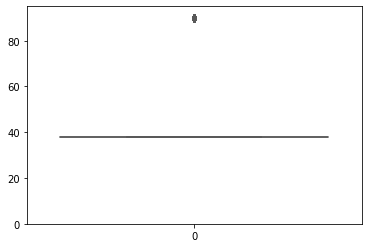

In [7]:
# Eliminar datdes fora de San Francisco
sns.boxplot(ds_copy['Y'])
plt.ylim(0, 95)
ds_copy = ds_copy[ds_copy['Y'] <= 40]

In [8]:
ds_copy.describe()

,X,Y
count,875659.000000,875659.000000
mean,-122.422770,37.767036
std,0.025281,0.024166
min,-122.513642,37.707879
25%,-122.432952,37.752427
50%,-122.416446,37.775421
75%,-122.406959,37.784380
max,-122.364937,37.819975


#### ANÀLISI VARIABLES EXPLICATIVES

In [9]:
# Dates
ds_copy['Dates'] = pd.to_datetime(ds_copy['Dates'], format='%Y-%m-%d %H:%M:%S')
ds_copy['Year'] = ds_copy['Dates'].dt.year
ds_copy['Month'] = ds_copy['Dates'].dt.month
ds_copy['Hour'] = ds_copy['Dates'].dt.hour
ds_copy['Day'] = ds_copy['Dates'].dt.day
ds_copy['Date'] = pd.to_datetime(ds_copy[['Year','Month','Day']], format='%Y-%m-%d')
DateAnalisi = ds_copy.copy()
DateAnalisi['Minute'] = ds_copy['Dates'].dt.minute
DateAnalisi[['Year','Month','Day','Hour','Minute']].describe()

,Year,Month,Day,Hour,Minute
count,875659.000000,875659.000000,875659.000000,875659.000000,875659.000000
mean,2008.712484,6.436043,15.573172,13.413670,20.170046
std,3.631338,3.429085,8.782849,6.549138,18.595969
min,2003.000000,1.000000,1.000000,0.000000,0.000000
25%,2006.000000,3.000000,8.000000,9.000000,0.000000
50%,2009.000000,6.000000,16.000000,14.000000,19.000000
75%,2012.000000,9.000000,23.000000,19.000000,33.000000
max,2015.000000,12.000000,31.000000,23.000000,59.000000


Valors únics: 879


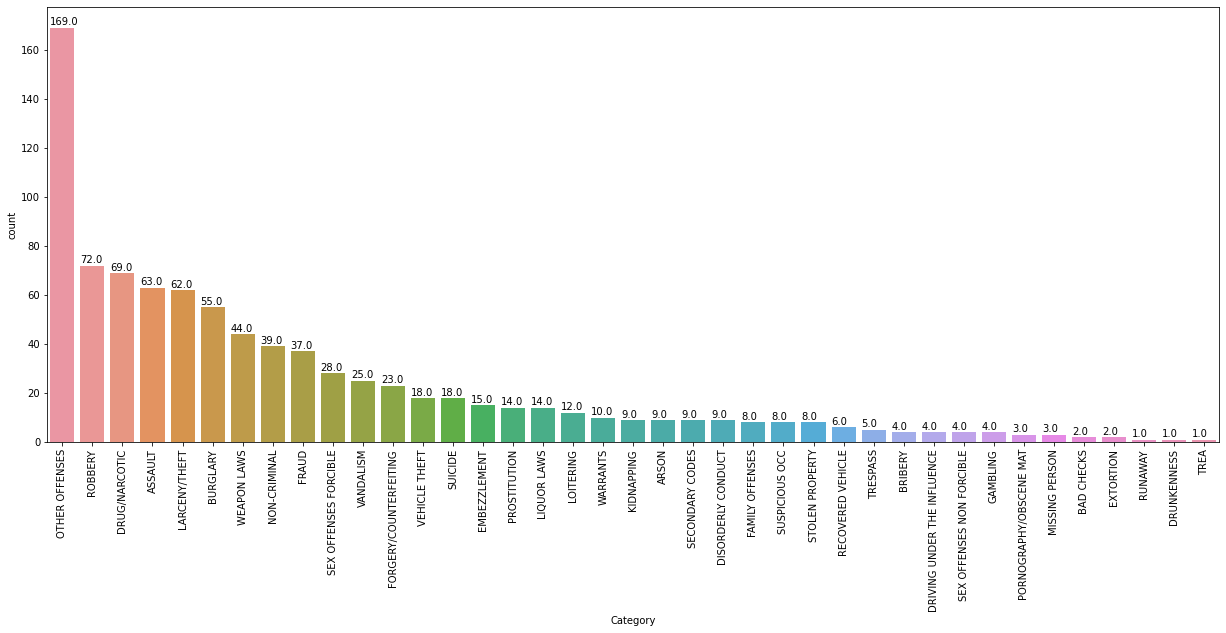

In [10]:
# Descript
print("Valors únics:", ds_copy['Descript'].nunique())
ct_Desc = pd.crosstab(ds_copy['Descript'], ds_copy['Category']); ct_Desc
stack_Desc = ct_Desc.stack().reset_index().rename(columns = {0:'count'}); stack_Desc
stack_Desc = stack_Desc[stack_Desc['count'] != 0]; stack_Desc
# GB_Desc = pd.DataFrame({'total' : stack_Desc.groupby( [ 'Category'] ).size()}).reset_index()
fig, ax = plt.subplots(1, 1, figsize=(21, 8))
sns.countplot(x=stack_Desc['Category'], order = stack_Desc['Category'].value_counts().index)
for p in ax.patches:
        ax.annotate('{}'.format(p.get_height()), (p.get_x(), p.get_height()+1))
ax.tick_params(axis='x', rotation=90)

Friday       133360
Wednesday    128818
Saturday     126463
Thursday     124746
Tuesday      124592
Monday       121292
Sunday       116388
Name: DayOfWeek, dtype: int64


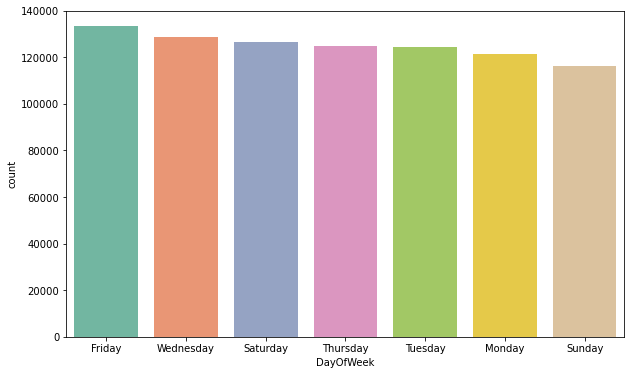

In [11]:
# Day Of Week
print(ds_copy['DayOfWeek'].value_counts())
fig = plt.figure(figsize=(10,6))
sns.countplot(x=ds_copy['DayOfWeek'], order = ds_copy['DayOfWeek'].value_counts().index)

SOUTHERN      156520
MISSION       119722
NORTHERN      105093
BAYVIEW        89089
CENTRAL        85262
TENDERLOIN     81627
INGLESIDE      78718
TARAVAL        65396
PARK           49159
RICHMOND       45073
Name: PdDistrict, dtype: int64


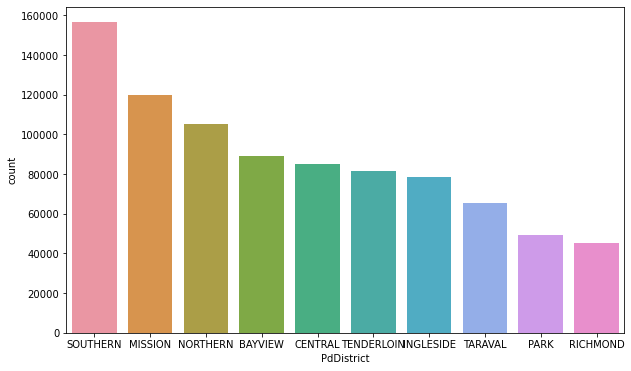

In [12]:
# PdDistrict
print(ds_copy['PdDistrict'].value_counts())
fig = plt.figure(figsize=(10,6))
sns.countplot(x=ds_copy['PdDistrict'], order = ds_copy['PdDistrict'].value_counts().index)
ax.tick_params(axis='x', rotation=90)

Número de resolucions total:  17


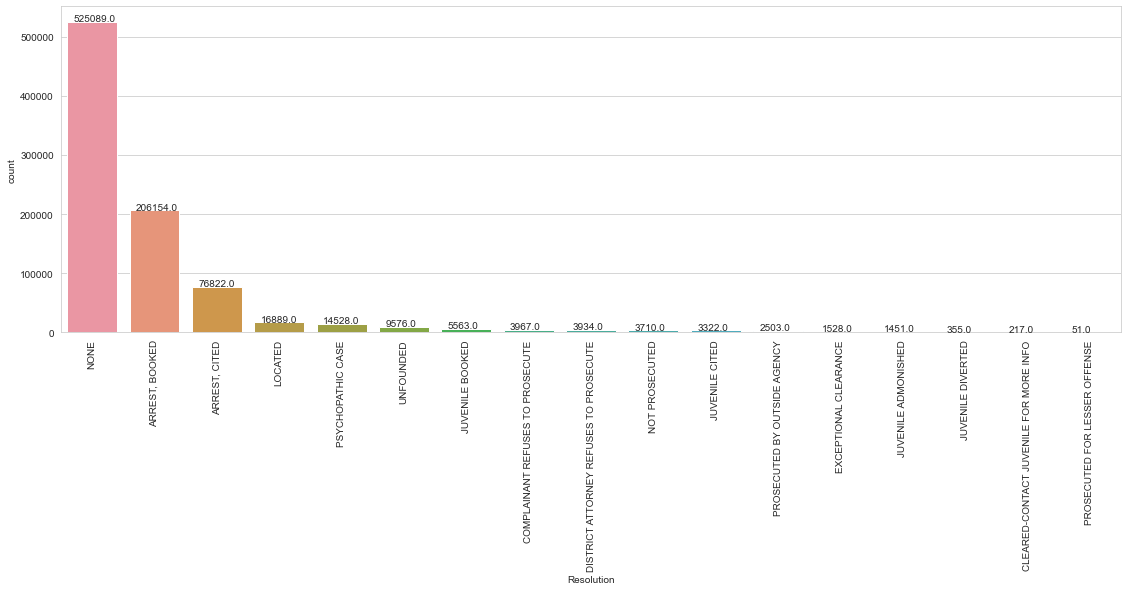

In [64]:
# Resolution
print("Número de resolucions total: ",ds_copy['Resolution'].nunique())
fig, ax = plt.subplots(1, 1, figsize=(19, 6))
sns.countplot(x=ds_copy['Resolution'], order = ds_copy['Resolution'].value_counts().index)
for p in ax.patches:
        ax.annotate('{}'.format(p.get_height()), (p.get_x()+0.1, p.get_height()+1000))
ax.tick_params(axis='x', rotation=90)

In [14]:
# Address
print("Valors únics:", ds_copy['Address'].nunique())
ds_copy.groupby(by=['Address']).size()

Valors únics: 23191


Address
0 Block of  HARRISON ST     1
0 Block of 10TH AV          5
0 Block of 10TH ST         49
0 Block of 11TH ST         48
0 Block of 12TH AV          7
                           ..
ZENO PL / FOLSOM ST         3
ZOE ST / BRANNAN ST        10
ZOE ST / BRYANT ST         10
ZOE ST / FREELON ST         4
ZOE ST / WELSH ST           3
Length: 23191, dtype: int64

#### ANÀLISI VARIABLE RESPOSTA

Número de categories total:  39


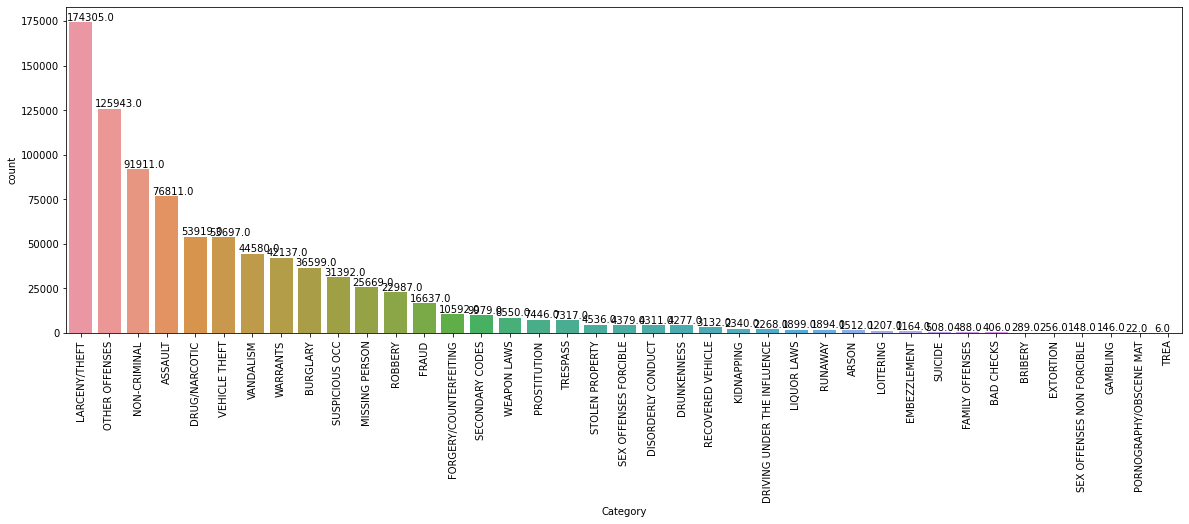

In [15]:
print("Número de categories total: ",ds_copy['Category'].nunique())
fig, ax = plt.subplots(1, 1, figsize=(20, 6))
sns.countplot(x=ds_copy['Category'], order = ds_copy['Category'].value_counts().index)
for p in ax.patches:
        ax.annotate('{}'.format(p.get_height()), (p.get_x()-0.1, p.get_height()+1000))
ax.tick_params(axis='x', rotation=90)

#### RELACIONS ENTRE VARIABLES

In [16]:
# Correlació entre variables Descript i Category
ct_Desc = pd.crosstab(ds_copy['Descript'], ds_copy['Category'], margins=True); ct_Desc

Category,ARSON,ASSAULT,BAD CHECKS,BRIBERY,BURGLARY,DISORDERLY CONDUCT,DRIVING UNDER THE INFLUENCE,DRUG/NARCOTIC,DRUNKENNESS,EMBEZZLEMENT,...,STOLEN PROPERTY,SUICIDE,SUSPICIOUS OCC,TREA,TRESPASS,VANDALISM,VEHICLE THEFT,WARRANTS,WEAPON LAWS,All
Descript,,,,,,,,,,,,,,,,,,,,,
ABANDONMENT OF CHILD,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,101
ABORTION,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,6
"ACCESS CARD INFORMATION, PUBLICATION OF",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,8
"ACCESS CARD INFORMATION, THEFT OF",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,311
ACCIDENTAL BURNS,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WEARING MASK OR DISGUISE FOR UNLAWFUL PURPOSE,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
WEARING THE APPAREL OF OPPOSITE SEX TO DECEIVE,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
WILLFUL CRUELTY TO CHILD,0,114,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,114


chi^2:  32811073.41158931
p-value:  0.0
Graus de llibertat:  34281


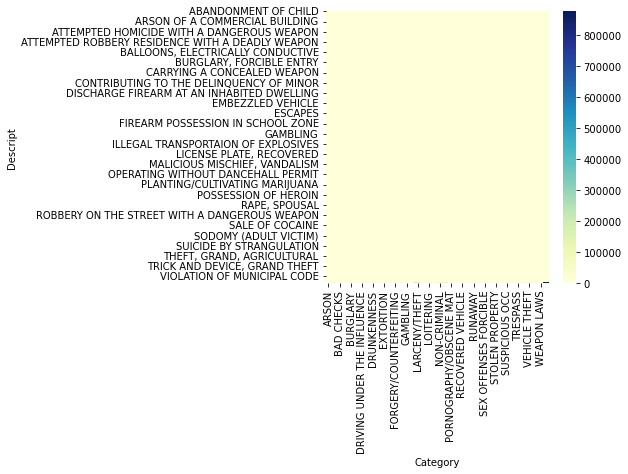

In [17]:
plt.figure(figsize=(5,5)) 
sns.heatmap(ct_Desc, cmap="YlGnBu")
c, p, gl, _ = stats.chi2_contingency(ct_Desc)
print("chi^2: ",c)
print("p-value: ",p)
print("Graus de llibertat: ",gl)

Com el pvalor és menor a 0.05, la hipotesi nula de que les variables són independents és nul·la, cosa que em quadra amb l'estudi fet. La majoria de valors expectants són menors a 5 cosa que fa dubtar de la fiabilitat de l'estudi però perque la taula de contingencia està plena de zeros, els valors no nuls són majors a 5.

In [18]:
# Descripció més recurrent per categoria
ct_Desc = pd.crosstab(ds_copy['Descript'], ds_copy['Category']); ct_Desc
stack_Desc = ct_Desc.stack().reset_index().rename(columns = {0:'count'}); stack_Desc
sum_Desc = ct_Desc.sum().reset_index().rename(columns = {0:'total'}); sum_Desc
DescrMerge = stack_Desc.merge(sum_Desc); DescrMerge
DescrData = DescrMerge[DescrMerge['count'] != 0].sort_values(by=['count','Category'], ascending=False).reset_index(drop = True)
DescrData['%'] = DescrData['count']/DescrData['total']*100
DescrData = DescrData.drop(columns = ['count','total'])
temp = pd.DataFrame()
for c in (DescrData['Category'].unique()):
    aux = DescrData[DescrData['Category'] == c]
    temp = pd.concat([temp, aux[0:1]])
temp.reset_index(drop=True)

,Descript,Category,%
0,GRAND THEFT FROM LOCKED AUTO,LARCENY/THEFT,34.282436
1,LOST PROPERTY,NON-CRIMINAL,34.270109
2,BATTERY,ASSAULT,35.691503
3,STOLEN AUTOMOBILE,VEHICLE THEFT,50.025141
4,"DRIVERS LICENSE, SUSPENDED OR REVOKED",OTHER OFFENSES,21.292966
5,WARRANT ARREST,WARRANTS,56.242732
6,SUSPICIOUS OCCURRENCE,SUSPICIOUS OCC,69.686544
7,"MALICIOUS MISCHIEF, VANDALISM OF VEHICLES",VANDALISM,39.739794
8,POSSESSION OF NARCOTICS PARAPHERNALIA,DRUG/NARCOTIC,18.620523
9,FOUND PERSON,MISSING PERSON,35.899334


In [19]:
# Crims simultanis
ds_MultCrims = ds_copy.groupby(['Dates', 'X', 'Y']).size()
ds_MultCrims = pd.DataFrame(ds_MultCrims)
ds_MultCrims = ds_MultCrims.reset_index()
ds_copy = ds_copy.merge(ds_MultCrims, how='right')
ds_copy.rename(columns={0:'NumMultCrims'}, inplace=True)

In [20]:
ds_copy['NumMultCrims'].value_counts()/sorted(ds_copy['NumMultCrims'].unique())

1     551788.0
2      96925.0
3      33855.0
4       4195.0
5       1355.0
6        434.0
7        159.0
8         69.0
9         38.0
10        13.0
11         9.0
12         4.0
13         1.0
Name: NumMultCrims, dtype: float64

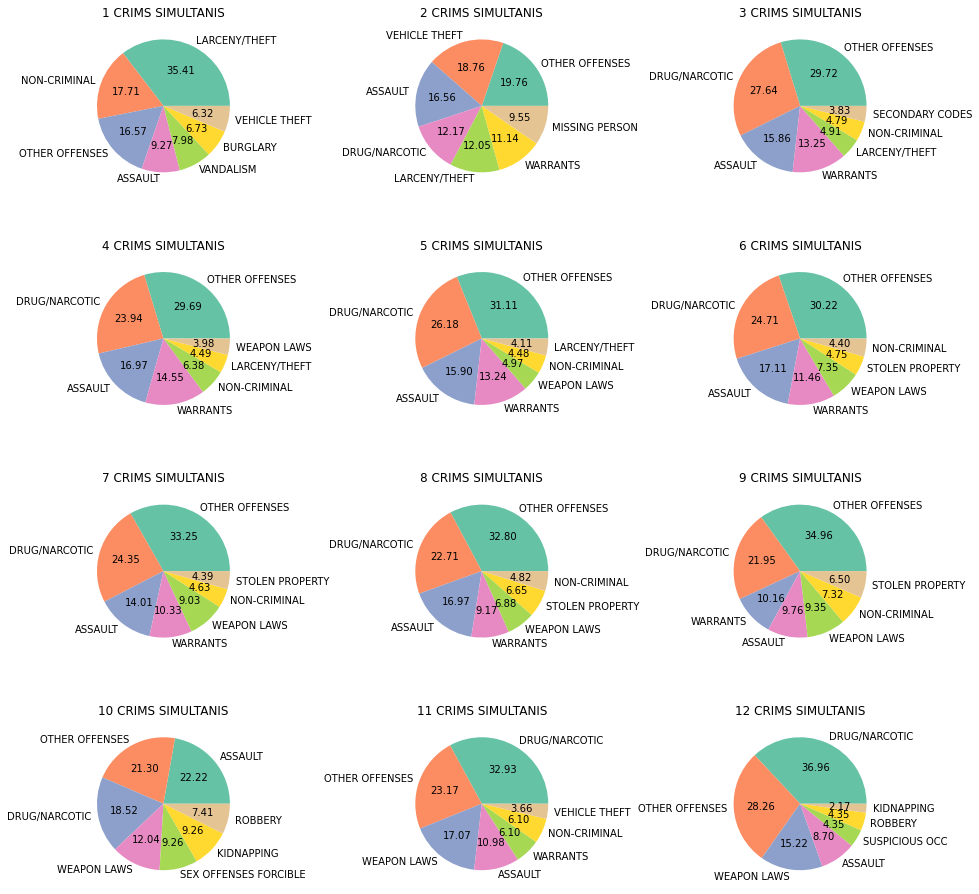

In [21]:
fig, ax = plt.subplots(nrows=4, ncols=3, figsize=(15,15))
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)
i=0
for r in range(4):
    for c in range(3):
        if (i < ds_copy['NumMultCrims'].nunique()):
            aux = ds_copy[ds_copy['NumMultCrims'] == i+1]
            im = ax[r, c].pie(aux['Category'].value_counts()[0:7], labels= aux['Category'].value_counts().keys()[0:7],
               colors = colors, autopct = '%.2f')
            ax[r, c].set_title("{} CRIMS SIMULTANIS".format(i+1))
            i=i+1
plt.show()

Ens donem compte que la categoria "Other offenses" el 83.43% de les vegades dins del conjut de dades es dona juntament amb altres cris simultanis. Una altra categoria candidata a ser classificada juntament amb una altra categoria és "Drug/Narcotic"

In [22]:
# Crims sense resolució
NoneData = ds_copy[ds_copy['Resolution'] == 'NONE']
print("El {:.2f}% de les dades del dataset original són crims no resolts".format(NoneData.size/ds_copy.size*100))

El 59.97% de les dades del dataset original són crims no resolts


SOUTHERN      93415
NORTHERN      70098
MISSION       62930
CENTRAL       60221
BAYVIEW       51551
INGLESIDE     50954
TARAVAL       44908
RICHMOND      32623
PARK          30795
TENDERLOIN    27594
Name: PdDistrict, dtype: int64


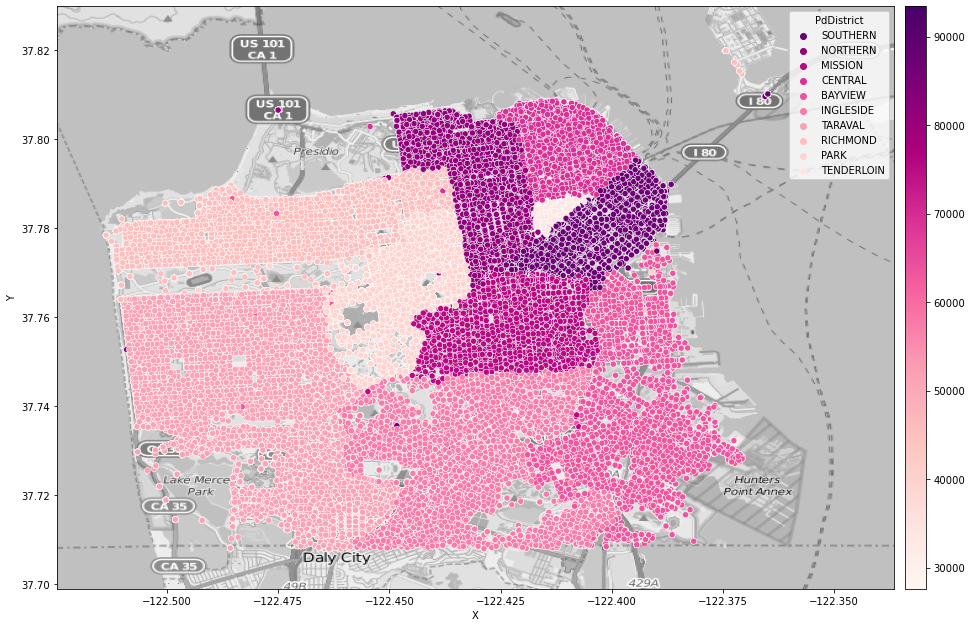

In [23]:
fig = plt.figure(figsize=(15,15))
ax1 = fig.add_subplot(1,1,1)
ax1.imshow(mapdata,extent=lon_lat, cmap=plt.get_cmap('gray'))
print(NoneData['PdDistrict'].value_counts())

hue_order = list(NoneData['PdDistrict'].value_counts().keys())
sc = sns.scatterplot(x = NoneData['X'], y = NoneData['Y'], hue = NoneData['PdDistrict'], hue_order = hue_order, palette='RdPu_r')
norm = plt.Normalize(NoneData['PdDistrict'].value_counts().max(), NoneData['PdDistrict'].value_counts().min())
sm = plt.cm.ScalarMappable(cmap='RdPu', norm=norm)
cax = fig.add_axes([ax1.get_position().x1+0.01,ax1.get_position().y0,0.02,ax1.get_position().height])
ax1.figure.colorbar(sm, cax = cax)
plt.show()

Friday       82347
Saturday     77982
Wednesday    74322
Thursday     73839
Tuesday      72711
Monday       72559
Sunday       71329
Name: DayOfWeek, dtype: int64


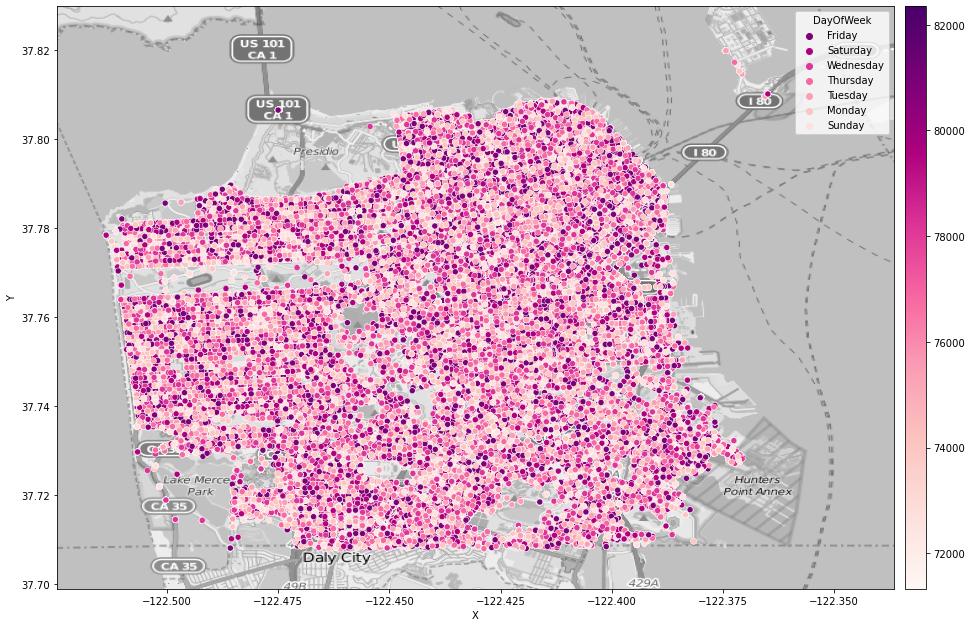

In [24]:
fig = plt.figure(figsize=(15,15))
ax1 = fig.add_subplot(1,1,1)
ax1.imshow(mapdata,extent=lon_lat, cmap=plt.get_cmap('gray'))
print(NoneData['DayOfWeek'].value_counts())

hue_order = list(NoneData['DayOfWeek'].value_counts().keys())
sc = sns.scatterplot(x = NoneData['X'], y = NoneData['Y'], hue = NoneData['DayOfWeek'], hue_order = hue_order, palette='RdPu_r')
norm = plt.Normalize(NoneData['DayOfWeek'].value_counts().max(), NoneData['DayOfWeek'].value_counts().min())
sm = plt.cm.ScalarMappable(cmap='RdPu', norm=norm)
cax = fig.add_axes([ax1.get_position().x1+0.01,ax1.get_position().y0,0.02,ax1.get_position().height])
ax1.figure.colorbar(sm, cax = cax)
plt.show()

D'aquestes dues gràfiques podem veure que tot i ser dades bastant equivalents, el districte amb més casos sense resoldre és el 'SOUTHERN' i el dia de la setmana amb més casos sense resoldre és 'Friday'

In [25]:
# Agrupem les categories de tal manera que les categories que formen menys d'un 10% dels crims registrats siguin només una dada
NoneDataCat = NoneData.copy()
ds_CatVal = pd.DataFrame(ds_copy['Category'].value_counts()).reset_index().rename(columns={'Category':'value', 'index':'Category'})
ds_CatVal['Cat2'] = ds_CatVal.loc[:, 'Category']
ds_CatVal.loc[ds_CatVal['value'] < 15000, 'Cat2'] = 'OTHER CRIMES'
dic_CatVal = ds_CatVal.drop(columns = ['value']).set_index('Category').to_dict()['Cat2']
NoneDataCat['Category'] = NoneDataCat['Category'].map(dic_CatVal)

LARCENY/THEFT     156047
NON-CRIMINAL       68162
VEHICLE THEFT      49162
ASSAULT            44687
VANDALISM          39089
OTHER OFFENSES     33125
BURGLARY           30706
OTHER CRIMES       30380
SUSPICIOUS OCC     27522
ROBBERY            17616
FRAUD              12538
MISSING PERSON      9231
DRUG/NARCOTIC       4632
WARRANTS            2192
Name: Category, dtype: int64


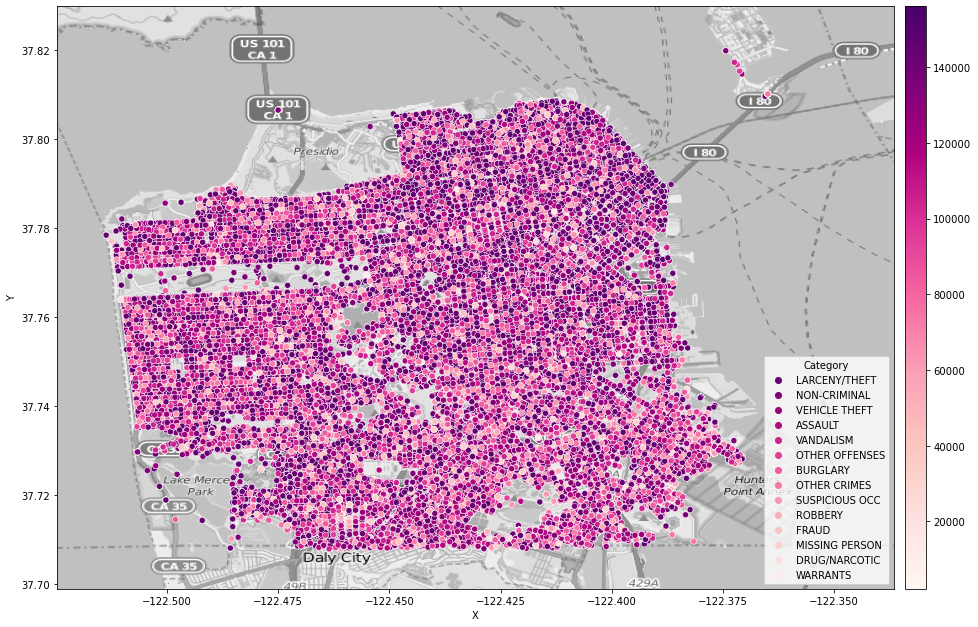

In [26]:
fig = plt.figure(figsize=(15,15))
ax1 = fig.add_subplot(1,1,1)
ax1.imshow(mapdata,extent=lon_lat, cmap=plt.get_cmap('gray'))
print(NoneDataCat['Category'].value_counts())

hue_order = list(NoneDataCat['Category'].value_counts().keys())
sc = sns.scatterplot(x = NoneDataCat['X'], y = NoneDataCat['Y'], hue = NoneDataCat['Category'], hue_order = hue_order, palette='RdPu_r')
norm = plt.Normalize(NoneDataCat['Category'].value_counts().max(), NoneDataCat['Category'].value_counts().min())
sm = plt.cm.ScalarMappable(cmap='RdPu', norm=norm)
cax = fig.add_axes([ax1.get_position().x1+0.01,ax1.get_position().y0,0.02,ax1.get_position().height])
ax1.figure.colorbar(sm, cax = cax)
plt.show()

Tenint en compte que la categoria *'Larceny/Theft'* correspon a un 20% del total dels crims classificats i aproximadament a un 30% dels crims amb resolució nul·la, no es pot arribar a la conclusió que els crims d'aquesta categoria són directament classificables en saber que no estàn resolts.
El mateix passa amb les seguents categories. 

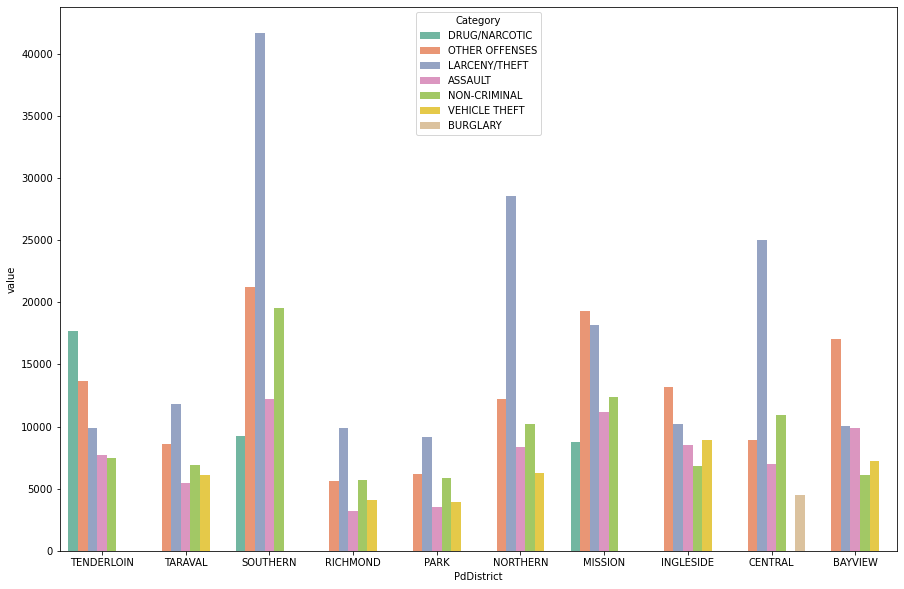

In [27]:
# Classificació majoritària per districte
ctDist_Cat = pd.crosstab(ds_copy['PdDistrict'], ds_copy['Category'])
Dist_Cat= ctDist_Cat.stack().reset_index().rename(columns= {0:'value'})
Dist_Cat2 = Dist_Cat.sort_values(by=['PdDistrict','value'], ascending=False).reset_index()
temp = pd.DataFrame()
for d in (Dist_Cat2['PdDistrict'].unique()):
    aux = Dist_Cat2[Dist_Cat2['PdDistrict'] == d]
    temp = pd.concat([temp, aux[0:5]])
fig, bar= plt.subplots(figsize= (15,10))
bar= sns.barplot(x= temp['PdDistrict'], y= temp['value'], hue= temp['Category'], palette='Set2')

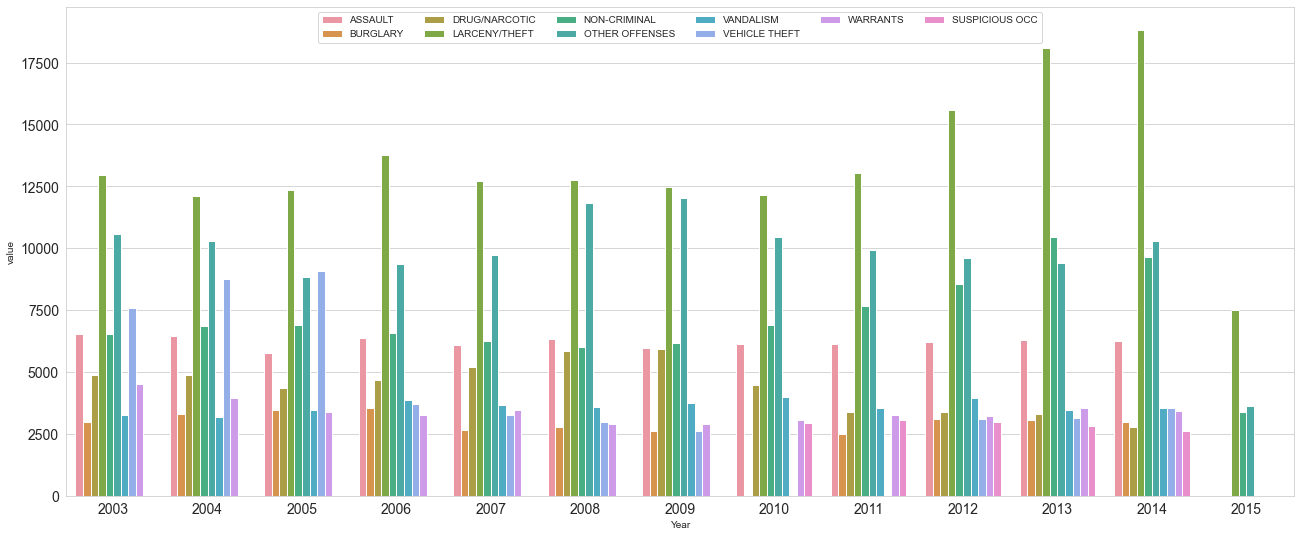

In [28]:
# Classificació majoritària per any
ct_year = pd.crosstab(ds_copy['Year'], ds_copy['Category'])
StackYear= ct_year.stack().reset_index().rename(columns= {0:'value'})
StackYear = StackYear[StackYear['value'] > 2500]
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(22, 9))
ax = sns.barplot(x=StackYear['Year'], y=StackYear['value'],  hue=StackYear['Category'])
ax.legend(loc='best',ncol=6)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

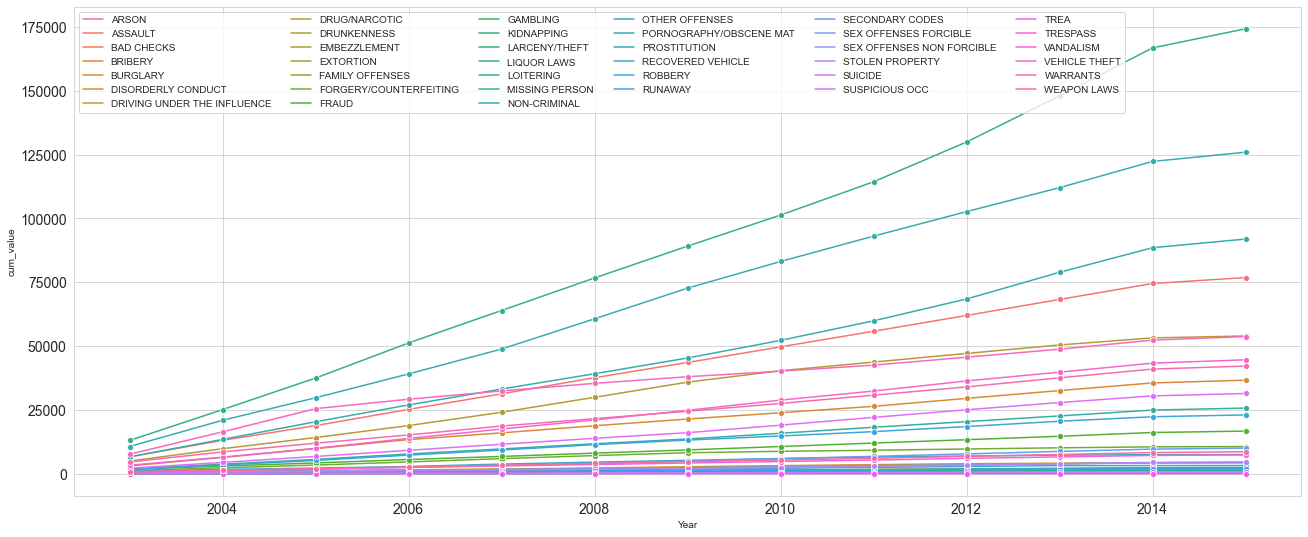

In [29]:
# Creixement anual per classificació
ct_year = pd.crosstab(ds_copy['Year'], ds_copy['Category'])
cm_year = ct_year.cumsum()
StackYear= cm_year.stack().reset_index().rename(columns = {0:'cum_value'})

sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(22, 9))
ax = sns.lineplot(x=StackYear['Year'], y=StackYear['cum_value'],  hue=StackYear['Category'], marker="o")
ax.legend(loc='best',ncol=6)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

No s'ha fet pca perque son variabes cateòriques i ja s'han eliminat abans els outliers

## MODELATGE

L'objectiu principal de la practica serà classificar a quina categoria pertany un crim segons el context en que aquest s'ha donat a terme.

(Si hi ha temps es podria predir si un cas segons les caracteristiques que comporta tidrà resolució no)

Per tal de classificar a quina categoria pertany el crim es modificarà el dataset per tal de tenir els atributs que inicialment es creu que serviràn a l'hora de predir (no categòrics) i per simplificar una mica el problema, es classificaràn les 10 classes més recurrents + una categoria d'altres tipus.

In [30]:
# El dataset actual té les columnes:
# 'Dates','Category', 'Descript', 'DayOfWeek', 'PdDistrict','Resolution', 'Address', 'X', 'Y', 'Year', 'Month', 'Hour','NumMultCrims'

ds_model = ds_copy.copy()

# Eliminem les columnes no necesaries per l'estudi
print("Eliminant columnes innecesàries...")
ds_model = ds_model.drop(columns=['Dates','Descript','Resolution','PdDistrict','Address','Day'])

# Transformació única variable categòrica a numèrica (la farem binària si es cap de setmana i divendres: 1 o no 0)
print("Transformant a binària 'DayOfWeek'...")
ds_model['DayOfWeek'] = ds_model['DayOfWeek'].replace(['Monday','Tuesday','Wednesday','Thursday'], 0)
ds_model['DayOfWeek'] = ds_model['DayOfWeek'].replace(['Friday','Saturday','Sunday'], 1)
ds_model = ds_model.rename(columns={"DayOfWeek": "Weekend"})

# Afegir columna (1 o 0) per indicar si el dia del crim era festiu
print("Afegint columna per controlar si el dia és festiu...")
ca_holidays = holidays.CA(years=[2003, 2015])
range_of_dates = pd.DatetimeIndex(ds_model['Date'])
Holidays = pd.DataFrame(index=range_of_dates,data={"is_holiday": [date in ca_holidays for date in range_of_dates]})
Holidays = Holidays.reset_index()
ds_model['is_holiday'] = Holidays['is_holiday'].astype(int)
ds_model = ds_model.drop(['Date'], axis=1)

# Afegir columna estació + one hot encoding
print("Afegint una columna per estació...")
ds_model['Month'] = ds_model['Month'].replace(list(range(3,7)), 'Spring')
ds_model['Month'] = ds_model['Month'].replace(list(range(7,10)), 'Summer')
ds_model['Month'] = ds_model['Month'].replace(list(range(10,13)), 'Outumn')
ds_model['Month'] = ds_model['Month'].replace(list(range(1,4)), 'Winter')
ds_model = ds_model.rename(columns={"Month": "Season"})
ds_ohe = pd.DataFrame()
ds_ohe = ds_model.copy()
ds_model = pd.concat([ds_ohe, pd.get_dummies(ds_ohe.Season, prefix='Season')], axis=1)
ds_model = ds_model.drop(['Season'], axis=1)

# Afegir columna controladora si es dia o nit (segons estació) + one hot encodin
print("Afegint una columna per nit o dia...")
Spring = ds_model[ds_model['Season_Spring'] == 1]
Outumn = ds_model[ds_model['Season_Outumn'] == 1]
Summer = ds_model[ds_model['Season_Summer'] == 1]
Winter = ds_model[ds_model['Season_Winter'] == 1]
Spring['Hour'] = Spring['Hour'].replace(list(range(7,20)), 'Day')
Spring['Hour'] = Spring['Hour'].replace(list(range(0,7)) + list(range(20,24)), 'Night')
Outumn['Hour'] = Outumn['Hour'].replace(list(range(7,20)), 'Day')
Outumn['Hour'] = Outumn['Hour'].replace(list(range(0,7)) + list(range(20,24)), 'Night')
Summer['Hour'] = Summer['Hour'].replace(list(range(6,22)), 'Day')
Summer['Hour'] = Summer['Hour'].replace(list(range(0,6)) + list(range(22,24)), 'Night')
Winter['Hour'] = Winter['Hour'].replace(list(range(8,18)), 'Day')
Winter['Hour'] = Winter['Hour'].replace(list(range(0,9)) + list(range(18,24)), 'Night')
ds_est = pd.DataFrame()
ds_est = pd.concat([Spring,Summer,Outumn,Winter])
ds_model = pd.concat([ds_est, pd.get_dummies(ds_est.Hour, drop_first=True, prefix='is')], axis=1)
ds_model = ds_model.drop(['Hour'], axis=1)

# Convertint les dades que suposen menys d'un 10% de les dades en una columna conjunta
print("Agrupant crims que suposen menys d'un 10% de les dades...")
ds_CatVal = pd.DataFrame(ds_model['Category'].value_counts()).reset_index().rename(columns={'Category':'value', 'index':'Category'})
ds_CatVal['Cat2'] = ds_CatVal.loc[:, 'Category']
ds_CatVal.loc[ds_CatVal['value'] < 15000, 'Cat2'] = 'OTHER CRIMES'
dic_CatVal = ds_CatVal.drop(columns = ['value']).set_index('Category').to_dict()['Cat2']
ds_model['Category'] = ds_model['Category'].map(dic_CatVal)

# Separem el target dels atributs
print("Separant dataset...")
enc = OrdinalEncoder() # transforma variables categòriques en numèriques
ds_model[["Category"]] = enc.fit_transform(ds_model[["Category"]])
y = ds_model['Category']
X = ds_model.drop(columns=['Category'])

# Visualització del nou dataset
print("")
print(ds_model.shape)
ds_model.head()

Eliminant columnes innecesàries...
Transformant a binària 'DayOfWeek'...
Afegint columna per controlar si el dia és festiu...
Afegint una columna per estació...
Afegint una columna per nit o dia...
Agrupant crims que suposen menys d'un 10% de les dades...
Separant dataset...

(875659, 12)


,Category,Weekend,X,Y,Year,NumMultCrims,is_holiday,Season_Outumn,Season_Spring,Season_Summer,Season_Winter,is_Night
0,13.0,0,-122.425892,37.774599,2015,2,0,0,1,0,0,1
1,8.0,0,-122.425892,37.774599,2015,2,0,0,1,0,0,1
2,8.0,0,-122.424363,37.800414,2015,1,0,0,1,0,0,1
3,4.0,0,-122.426995,37.800873,2015,1,0,0,1,0,0,1
4,4.0,0,-122.438738,37.771541,2015,1,0,0,1,0,0,1


mini barplots con cada atri

##### Correlació dels nous atributs

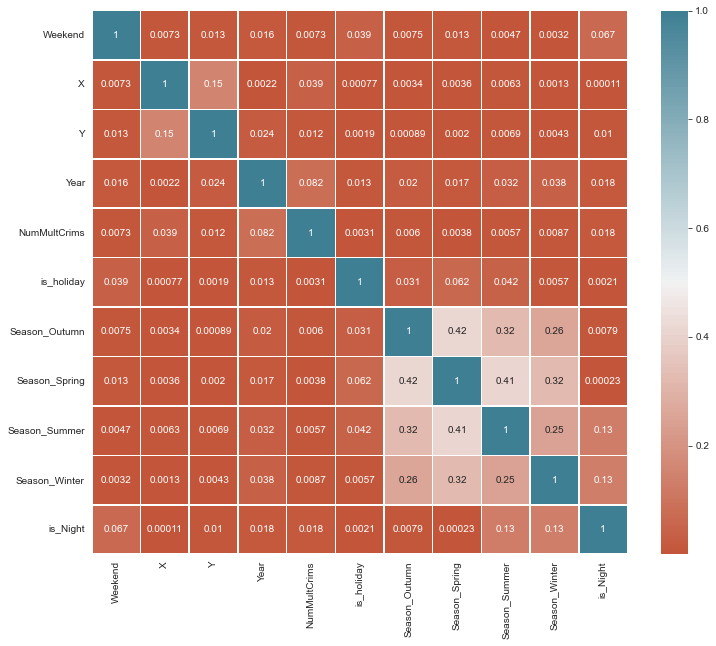

In [31]:
# Es fa el heatmap en valor absolut per veure més clarament les correlacions entre les variables
# El que interessa és saber si les variables estan correlacionades o no, no si ho estan positiva o negativament
correlacio = X.corr()
plt.figure(figsize=(12,10))
ax = sns.heatmap(abs(correlacio), annot=True, linewidths=.5, cmap = sns.diverging_palette(20, 220, n=200))

Tecnica sin supervisión: correlación --> ens quedem les variables menys correlacionades entre elles

In [32]:
# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
# summarize
print('Train', X_train.shape, y_train.shape)
print('Test', X_test.shape, y_test.shape)

Train (612961, 11) (612961,)
Test (262698, 11) (262698,)


In [33]:
y.describe()

count    875659.000000
mean          6.093417
std           3.672801
min           0.000000
25%           4.000000
50%           6.000000
75%           8.000000
max          13.000000
Name: Category, dtype: float64

In [34]:
#Normalitzem les dades
scaler = StandardScaler()
X_scale = pd.DataFrame(scaler.fit_transform(X))
X_cols = X.columns
X_scale.columns = X_cols

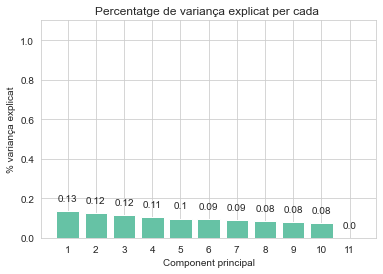

In [35]:
#es fa un pca per visualitzar els outliers
model = PCA(n_components=11)
model.fit(X_scale)
data_pca = pd.DataFrame(
    data = model.components_,
    columns = X.columns,
    index = ['PC1','PC2','PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10', 'PC11'])
X_pca = model.transform(X_scale)

# Percentatge de variança de cada component
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))
ax.bar(
    x      = np.arange(model.n_components_) + 1,
    height = model.explained_variance_ratio_
)

for x_for, y_for in zip(np.arange(len(data_pca.columns)) + 1, model.explained_variance_ratio_):
    label = round(y_for, 2)
    ax.annotate(
        label,
        (x_for,y_for),
        textcoords="offset points",
        xytext=(0,10),
        ha='center'
    )

ax.set_xticks(np.arange(model.n_components_) + 1)
ax.set_ylim(0, 1.1)
ax.set_title('Percentatge de variança explicat per cada ')
ax.set_xlabel('Component principal')
ax.set_ylabel('% variança explicat');

#Conclusió: com les variances són molt baixes, no val la pena fer un PCA.

#### FEATURE IMPORTANCE & SELECTION

Feature importances:
[0.01457856 0.38816662 0.39449019 0.11749769 0.04417167 0.00797804
 0.00660803 0.00707184 0.00634351 0.0053201  0.00777376]


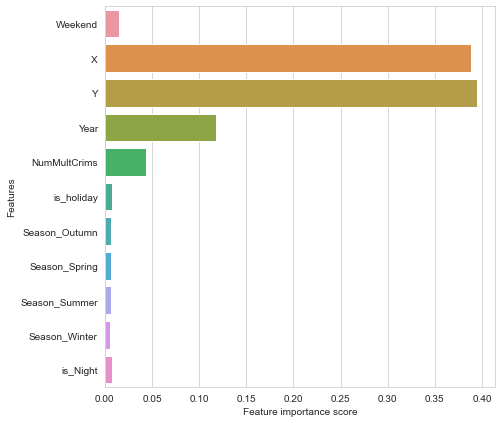

Feature selection:
['Weekend' 'X' 'Y' 'Year' 'NumMultCrims']
Train accuracy model sencer:
0.7859651755984476
Test accuracy model sencer:
0.27863173682327236


In [53]:
# Random Forest Importance
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(random_state=0)
model.fit(X_train, y_train)

importances = model.feature_importances_
print("Feature importances:")
print(importances)

features = X.columns
f, ax = plt.subplots(figsize=(7, 7))
ax = sns.barplot(x=importances, y=features)
ax.set_xlabel("Feature importance score")
ax.set_ylabel("Features")
plt.show()

FSelect = np.array(features)[importances > 0.01]
print("Feature selection:")
print(FSelect)

print("Train accuracy model sencer:")
print(model.score(X_train, y_train))

print("Test accuracy model sencer:")
print(model.score(X_test, y_test))

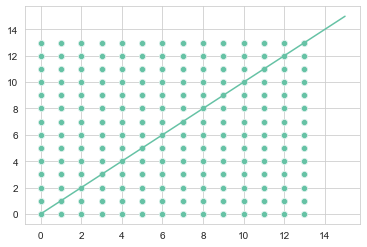

In [37]:
y_pred = model.predict(X_test)
x = np.linspace(0, 15, 100)
sns.scatterplot(x = np.array(y_test), y = y_pred)
plt.plot(x,x)

In [38]:
def visualize_confusion_matrix(y_pred, y_real):
    #mostra la matriu de confusió i clcula l'accuracy de la matriu
    cm = confusion_matrix(y_real, y_pred)
    acc = np.sum(cm.diagonal())/np.sum(cm)
    plt.subplots(figsize=(10, 6))
    sns.heatmap(cm, annot = True, fmt = 'g')
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()
    print(f"Accuracy: {acc}")

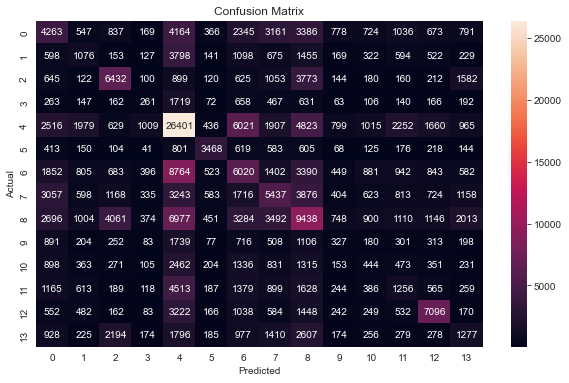

Accuracy: 0.27863173682327236


In [39]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier
visualize_confusion_matrix(model.predict(X_test),y_test)

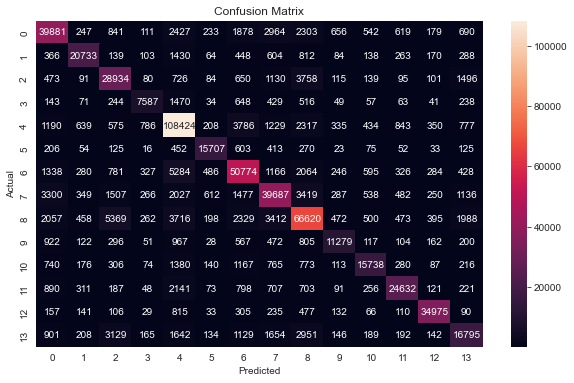

Accuracy: 0.7859651755984476


In [40]:
visualize_confusion_matrix(model.predict(X_train),y_train)

In [41]:
# Feature selection with Lasso regression --> relacions lineals
features = X.columns

pipeline = Pipeline([('scaler', StandardScaler()),('model',Lasso())])

search = GridSearchCV(pipeline, {'model__alpha':np.arange(0.1,3,0.1)}, cv = 5,scoring= 'neg_mean_squared_error',verbose=3)
search.fit(X_train, y_train)

print("Find best params:")
search.best_params_

print("Feature importances:")
Fimp = search.best_estimator_[1].coef_
print(Fimp)

print("Feature selection:")
Coef = np.array(features)[Fimp != 0]
print(Coef)

Fitting 5 folds for each of 29 candidates, totalling 145 fits
[CV] model__alpha=0.1 ................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .................. model__alpha=0.1, score=-13.457, total=   0.3s
[CV] model__alpha=0.1 ................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV] .................. model__alpha=0.1, score=-13.341, total=   0.3s
[CV] model__alpha=0.1 ................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s


[CV] .................. model__alpha=0.1, score=-13.337, total=   0.3s
[CV] model__alpha=0.1 ................................................
[CV] .................. model__alpha=0.1, score=-13.459, total=   0.3s
[CV] model__alpha=0.1 ................................................
[CV] .................. model__alpha=0.1, score=-13.386, total=   0.3s
[CV] model__alpha=0.2 ................................................
[CV] .................. model__alpha=0.2, score=-13.500, total=   0.3s
[CV] model__alpha=0.2 ................................................
[CV] .................. model__alpha=0.2, score=-13.387, total=   0.3s
[CV] model__alpha=0.2 ................................................
[CV] .................. model__alpha=0.2, score=-13.388, total=   0.3s
[CV] model__alpha=0.2 ................................................
[CV] .................. model__alpha=0.2, score=-13.507, total=   0.3s
[CV] model__alpha=0.2 ................................................
[CV] .

[CV] ... model__alpha=1.3000000000000003, score=-13.531, total=   0.7s
[CV] model__alpha=1.3000000000000003 .................................
[CV] ... model__alpha=1.3000000000000003, score=-13.419, total=   0.6s
[CV] model__alpha=1.3000000000000003 .................................
[CV] ... model__alpha=1.3000000000000003, score=-13.420, total=   0.5s
[CV] model__alpha=1.3000000000000003 .................................
[CV] ... model__alpha=1.3000000000000003, score=-13.539, total=   0.5s
[CV] model__alpha=1.3000000000000003 .................................
[CV] ... model__alpha=1.3000000000000003, score=-13.466, total=   0.6s
[CV] model__alpha=1.4000000000000001 .................................
[CV] ... model__alpha=1.4000000000000001, score=-13.531, total=   0.5s
[CV] model__alpha=1.4000000000000001 .................................
[CV] ... model__alpha=1.4000000000000001, score=-13.419, total=   0.5s
[CV] model__alpha=1.4000000000000001 .................................
[CV] .

[CV] ... model__alpha=2.4000000000000004, score=-13.539, total=   0.4s
[CV] model__alpha=2.4000000000000004 .................................
[CV] ... model__alpha=2.4000000000000004, score=-13.466, total=   0.4s
[CV] model__alpha=2.5000000000000004 .................................
[CV] ... model__alpha=2.5000000000000004, score=-13.531, total=   0.4s
[CV] model__alpha=2.5000000000000004 .................................
[CV] ... model__alpha=2.5000000000000004, score=-13.419, total=   0.4s
[CV] model__alpha=2.5000000000000004 .................................
[CV] ... model__alpha=2.5000000000000004, score=-13.420, total=   0.4s
[CV] model__alpha=2.5000000000000004 .................................
[CV] ... model__alpha=2.5000000000000004, score=-13.539, total=   0.5s
[CV] model__alpha=2.5000000000000004 .................................
[CV] ... model__alpha=2.5000000000000004, score=-13.466, total=   0.5s
[CV] model__alpha=2.6 ................................................
[CV] .

[Parallel(n_jobs=1)]: Done 145 out of 145 | elapsed:  1.1min finished


Find best params:
Feature importances:
[-0.         -0.         -0.16807233 -0.04549867  0.          0.
 -0.          0.          0.          0.          0.02578593]
Feature selection:
['Y' 'Year' 'is_Night']


El problema de utilitzar la Lasso Regression és que no té en compte les possibles relacions entre atributs no lineals, per tant, en aquest és millor utilitzar el Random Forest Classifier.

#### MODEL SELECTION

In [65]:
import time
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from xgboost import XGBClassifier #pip install xgboost
import lightgbm as lgb
from sklearn.metrics import accuracy_score



#Random Forest
def RandomForest():
    modelrfcla = RandomForestClassifier(n_estimators=50,random_state=9,n_jobs=-1).fit(X_train[FSelect],y_train)
    score_test = modelrfcla.score(X_test[FSelect], y_test)
    score_train = modelrfcla.score(X_train[FSelect], y_train)
    RF_cm = confusion_matrix(y_test, modelrfcla.predict(X_test[FSelect]))
    return modelrfcla, score_test, score_train, RF_cm

# Gradient Boosting
def GradBoost():
    modelgb = GradientBoostingClassifier(n_estimators=20, learning_rate=learning_rate, max_features=2, max_depth=2, random_state=0)
    modelgb.fit(X_train[FSelect], y_train)
    score_test = modelgb.score(X_test[FSelect], y_test)    
    score_train  = modelgb.score(X_train[FSelect], y_train)
    GB_cm = confusion_matrix(y_test, modelgb.predict(X_test[FSelect]))
    return modelgb, score_test, score_train, GB_cm

# Extreme gradient boosting
def XGradBoost():
    modelxgb = XGBClassifier()
    modelxgb.fit(X_train[FSelect], y_train)
    score_test = modelxgb.score(X_test[FSelect], y_test)    
    score_train  = modelxgb.score(X_train[FSelect], y_train)
    XGB_cm = confusion_matrix(y_test, modelxgb.predict(X_test[FSelect]))
    return modelxgb, score_test, score_train, XGB_cm

# Light Gradient Boosting Machine
def LightGBM():
    modelLGB = lgb.LGBMClassifier().fit(X_train[FSelect], y_train)
    score_test = modelLGB.score(X_test[FSelect], y_test)    
    score_train  = modelLGB.score(X_train[FSelect], y_train)
    LGB_cm = confusion_matrix(y_test, modelLGB.predict(X_test[FSelect]))
    return modelLGB, score_test, score_train, LGB_cm

# no tinc explainability --> no sabem q pasa dins
def RedNeuronal():
    
    pass

def OneVsRest():
    pass

from sklearn.neighbors import KNeighborsClassifier
def KNN():
    modelknn = KNeighborsClassifier(n_neighbors=3).fit(X_train[FSelect],y_train)
    score_test = modelknn.score(X_test[FSelect], y_test)
    score_train = modelknn.score(X_train[FSelect], y_train)
    KNN_cm = confusion_matrix(y_test, modelknn.predict(X_test[FSelect]))
    return modelknn, score_test, score_train, KNN_cm


In [66]:
print("MODEL KNN")
t0=time.time()
KNN, knn_acctest, knn_acctrain, KNN_cm = KNN()
print('Time taken:' , time.time()-t0)
print("Accuracy test:",knn_acctest)
print("Accuracy train:",knn_acctrain)

MODEL KNN
Time taken: 480.9258236885071
Accuracy test: 0.24890178075204228
Accuracy train: 0.46971667039175413


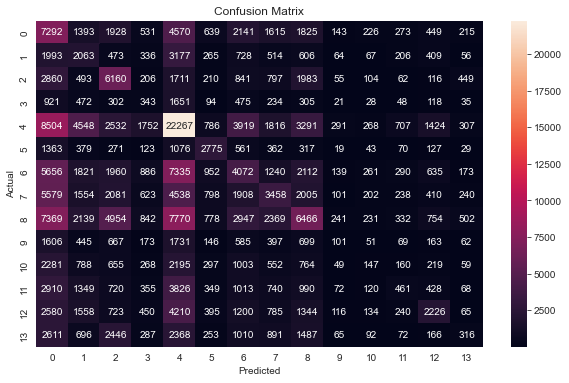

Accuracy: 0.22134542326169213


In [51]:
visualize_confusion_matrix(KNN.predict(X_test[FSelect]),y_test)

In [54]:
y_train.value_counts()

4.0     121893
8.0      88249
6.0      64379
7.0      55337
0.0      53571
2.0      37872
12.0     37671
11.0     31179
13.0     29377
1.0      25642
10.0     21955
5.0      18154
9.0      16092
3.0      11590
Name: Category, dtype: int64

In [56]:
y_train_cp = y_train.copy()
X_train_cp = X_train.copy()

In [73]:
# check version number
import imblearn
print(imblearn.__version__)
# sm = over_sampling.SMOTE(random_state=2)
# X_train_res,y_train_res = sm.fit_resample(X_train_cp,y_train_cp)

ImportError: cannot import name '_ClassNamePrefixFeaturesOutMixin' from 'sklearn.base' (C:\Users\Marina\anaconda3\lib\site-packages\sklearn\base.py)

In [ ]:

t0=time.time() 
result = Parallel(n_jobs = 5)(delayed(MultipleDT)(atribut) for atribut in llistaFS)

for atribut,r in zip(llistaFS,result): 
        print('Accuracy',atribut,':',r) #r = [acc_test, acc_train]
print('Time taken :' , time.time()-t0, "s")

print("Null accuracy: ",y_test.value_counts()[0]/sum(y_test.value_counts())) #Percentatge de 0 al y_test

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import Perceptron
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
# SVM
def MultipleSVC(k):
    model = svm.SVC(kernel = k) #classificació
    model.fit(X_train[['Y']], y_train)
    y_pred = model.predict(X_test[['Y']])
    score = accuracy_score(y_test,y_pred)
    return score

# LOGISTIC REGRESSION
def LogReg():
    logreg = LogisticRegression(solver='saga', random_state=0)
    logreg.fit(X_train[llistaFS], y_train)
    score_test = logreg.score(X_test[llistaFS], y_test)
    score_train = logreg.score(X_train[llistaFS], y_train)
    LM_cm = confusion_matrix(y_test, logreg.predict(X_test[llistaFS]))
    return logreg, score_test, score_train, LM_cm
    
# KNN
def KNN(n=5):
    knn = KNeighborsClassifier(n_neighbors=n)
    knn.fit(X_train[llistaFS],y_train)
    score_test = knn.score(X_test[llistaFS], y_test)
    score_train = knn.score(X_train[llistaFS], y_train)
    KNN_cm = confusion_matrix(y_test, knn.predict(X_test[llistaFS]))
    return knn, score_test, score_train, KNN_cm
    
#Preceptron model
def Perc():
    clf = Perceptron(random_state=0)
    clf.fit(X_train, y_train)
    score_test = clf.score(X_test,y_test)
    score_train = clf.score(X_train,y_train)
    return clf, score_test, score_train

#Random Forest
def RandomForest():
    modelrfcla = RandomForestClassifier(n_estimators=50,random_state=9,n_jobs=-1).fit(X_train[llistaFS],y_train)
    score_test = modelrfcla.score(X_test[llistaFS], y_test)
    score_train = modelrfcla.score(X_train[llistaFS], y_train)
    RF_cm = confusion_matrix(y_test, modelrfcla.predict(X_test[llistaFS]))
    return modelrfcla, score_test, score_train, RF_cm

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split

In [ ]:
# SVM
# print("MODEL SVM")
# t0=time.time()        
# kernels = ["sigmoid", "rbf"]
# result = Parallel(n_jobs = 2)(delayed(MultipleSVC)(kernel) for kernel in kernels)
# for kernel,r in zip(kernels,result):
#         print('Accuracy',kernel,':',r)
# print('Time taken :' , time.time()-t0)

# LR
print("MODEL LOGISTIC REGRESSION")
t0=time.time()  
LR, log_acctest, log_acctrain, LR_cm = LogReg()
print("Accuracy test:",log_acctest)
print("Accuracy train:",log_acctrain)
print('Time taken :' , time.time()-t0)

# KNN
print("MODEL KNN")
t0=time.time()
KNN, knn_acctest, knn_acctrain, KNN_cm = KNN()
print("Accuracy test:",knn_acctest)
print("Accuracy train:",knn_acctrain)
print('Time taken :' , time.time()-t0)

#Perceptron
print("MODEL PERCEPTRON")
t0=time.time() 
Perc, perc_acctest, perc_acctrain = Perc()
print("Accuracy test:",perc_acctest)
print("Accuracy train:",perc_acctrain)
print('Time taken :' , time.time()-t0)

#Random Forest
print("MODEL RANDOM FOREST")
t0=time.time() 
RF, RF_acctest, RF_acctrain, RF_cm = RandomForest()
print("Accuracy test:",RF_acctest)
print("Accuracy train:",RF_acctrain)
print('Time taken :' , time.time()-t0)